In [1]:
import sys,os
if not(os.path.isfile("train_nominal_000.h5")):
    if sys.platform=="darwin": #MAC OSX
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz --output train_nominal_000.h5.gz
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz --output test_nominal_000.h5.gz
    elif sys.platform == "linux" or sys.platform == "linux2":
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz
    !gunzip -f train_nominal_000.h5.gz
    !gunzip -f test_nominal_000.h5.gz

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchinfo import summary

from sklearn import metrics
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [3]:
class ATLASH5HighLevelDataset(torch.utils.data.Dataset):
    def transform(self,data,transform=True):
        if transform:
            #Calculate some metrics from subsample of total
            vals=[]
            Njets=np.max([1000,data.len()])
            for jet in range(Njets): vals.append(data[jet])
            maxval=np.max(vals)
            minval=np.min(vals)
            return (data-minval)/(maxval-minval)
        else:
            return data

    def __init__(self, file_path, transform=True, return_pt=False):
        super(ATLASH5HighLevelDataset, self).__init__()
        h5_file = h5py.File(file_path , 'r')
        self.data=torch.tensor([])
    
        self.C2=self.transform(h5_file['fjet_C2'],transform=transform)
        self.D2=self.transform(h5_file['fjet_D2'],transform=transform)
        self.ECF1=self.transform(h5_file['fjet_ECF1'],transform=transform)
        self.ECF2=self.transform(h5_file['fjet_ECF2'],transform=transform)
        self.ECF3=self.transform(h5_file['fjet_ECF3'],transform=transform)
        self.L2=self.transform(h5_file['fjet_L2'],transform=transform)
        self.L3=self.transform(h5_file['fjet_L3'],transform=transform)
        self.Qw=self.transform(h5_file['fjet_Qw'],transform=transform)
        self.Split12=self.transform(h5_file['fjet_Split12'],transform=transform)
        self.Split23=self.transform(h5_file['fjet_Split23'],transform=transform)
        self.Tau1_wta=self.transform(h5_file['fjet_Tau1_wta'],transform=transform)
        self.Tau2_wta=self.transform(h5_file['fjet_Tau2_wta'],transform=transform)
        self.Tau3_wta=self.transform(h5_file['fjet_Tau3_wta'],transform=transform)
        self.Tau4_wta=self.transform(h5_file['fjet_Tau4_wta'],transform=transform)
        self.ThrustMaj=self.transform(h5_file['fjet_ThrustMaj'],transform=transform)
        self.m=self.transform(h5_file['fjet_m'],transform=transform)
    
        self.pt = h5_file['fjet_pt']
        self.labels = h5_file['labels']
        if "training_weights" in h5_file:
            self.hasWeights=True
            self.weights = h5_file['training_weights']
        else:
            self.hasWeights=False
    
        self.return_pt = return_pt
    
    def __getitem__(self, index):
        self.data=torch.tensor([self.D2[index],self.C2[index],self.ECF1[index],self.ECF2[index],self.ECF3[index],self.L2[index],self.L3[index],self.Qw[index],self.Split12[index],self.Split23[index],self.Tau1_wta[index],self.Tau2_wta[index],self.Tau3_wta[index],self.Tau4_wta[index],self.ThrustMaj[index],self.m[index]])
    
        if self.return_pt:
            self.data=self.data,torch.tensor([self.pt[index]])
    
        if self.hasWeights:
            return self.data,torch.tensor(self.labels[index],dtype=torch.int64),torch.tensor(self.weights[index])
        else:
            return self.data,torch.tensor(self.labels[index],dtype=torch.int64),torch.tensor(1)
    
    def __len__(self):
        return len(self.labels)

In [4]:
def get_ATLAS_inputs(directory,network,batch_size=2**8,return_pt=False,transform=True):
    
    #Get list of input files
    training_list=[]
    testing_list=[]
    for file in sorted(os.listdir(directory)):
        if not ".h5" in file: continue
        if "train" in file:
            print("Using file %s for training"%(directory+"/"+file))
            training_list.append(directory+"/"+file)
        elif "test" in file:
            print("Using file %s for testing"%(directory+"/"+file))
            testing_list.append(directory+"/"+file)
    
    #concat them
    training_DSlist=[]
    testing_DSlist=[]
    if network!="HL":
        for file in training_list: training_DSlist.append(ATLASH5LowLevelDataset(file,return_pt=return_pt,transform=transform))
        for file in testing_list: testing_DSlist.append(ATLASH5LowLevelDataset(file,return_pt=return_pt,transform=transform))
    else:
        for file in training_list: training_DSlist.append(ATLASH5HighLevelDataset(file,return_pt=return_pt,transform=transform))
        for file in testing_list: testing_DSlist.append(ATLASH5HighLevelDataset(file,return_pt=return_pt,transform=transform))
    training_data = ConcatDataset(training_DSlist)
    testing_data = ConcatDataset(testing_DSlist)
    
    #load them into torch dataloaders 
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
    test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)
    
    #return
    return train_dataloader, test_dataloader

In [5]:
class DNNetwork(nn.Module):
    def __init__(self,Ninputs,useConstituents=False):
        super().__init__()
        self.useConstituents=useConstituents
    
        if self.useConstituents: self.flatten = nn.Flatten()
        #self.norm=nn.BatchNorm1d(Ninputs)
        self.fc1= nn.Linear(Ninputs, 512)
        self.act1=nn.ReLU()
        self.fc2= nn.Linear(512, 512)
        self.act2=nn.ReLU()
        self.fc3= nn.Linear(512, 512)
        self.act3=nn.ReLU()
        self.fc4= nn.Linear(512, 2)
    
    def forward(self, x):
        if self.useConstituents: x = self.flatten(x)
        #x=self.norm(x)
        f1=self.act1(self.fc1(x))
        f2=self.act2(self.fc2(f1))
        f3=self.act3(self.fc3(f2))
        logits = self.fc4(f3)
        return logits

In [6]:
train_dataloader,test_dataloader=get_ATLAS_inputs("./","HL",batch_size=2**8,return_pt=True)

Using file .//test_nominal_000.h5 for testing
Using file .//train_nominal_000.h5 for training


In [7]:
Ndim = len(train_dataloader.dataset[0][0][0])
device = "cpu"
model = DNNetwork(Ndim).to(device)
model.load_state_dict(torch.load("model.pth"))
print(model)

DNNetwork(
  (fc1): Linear(in_features=16, out_features=512, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=512, out_features=2, bias=True)
)


In [8]:
#Load information into numpy arrays
def load_score(dataloader):
    ys=np.array([])
    preds_raw=np.empty((0,2))
    weights=np.array([])
    pts=np.array([])
    with torch.no_grad():
        for (X, pt), y, w in dataloader:
            #Get prediction
            pred=model(X)
            pred=torch.sigmoid(pred)

            #append info
            preds_raw=np.concatenate([preds_raw,pred.numpy()])
            ys=np.concatenate([ys,y.numpy().flatten()])
            pts=np.concatenate([pts,pt.numpy().flatten()])
            weights=np.concatenate([weights,pt.numpy().flatten()])
    return preds_raw,ys,weights,pts

In [9]:
preds_raw,ys,weights,pts=load_score(train_dataloader)

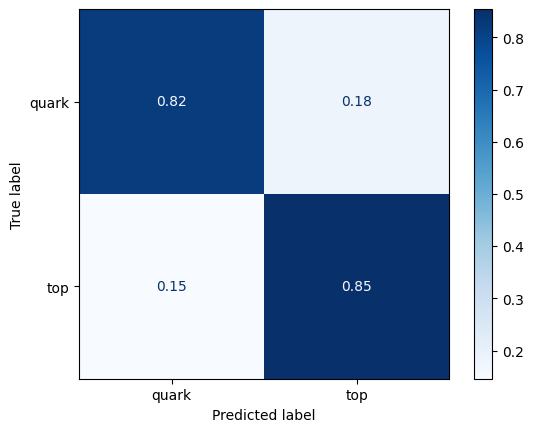

In [10]:
#make confusion matrix
disp=metrics.ConfusionMatrixDisplay.from_predictions(ys, np.argmax(preds_raw,axis=1),normalize="true",cmap="Blues",display_labels=["quark","top"])
plt.savefig("confusion.pdf") 

In [11]:
#Decision rule
preds=np.log(preds_raw[:,0])/np.log(preds_raw[:,1])

/Users/les/venv/CometaTutorial/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


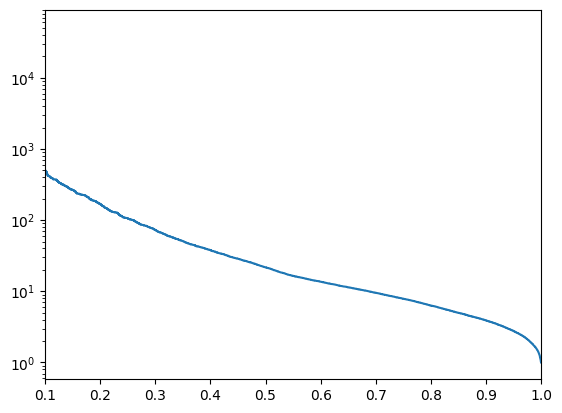

In [12]:
#make ROC curve
fpr, tpr, thresholds = metrics.roc_curve(ys, preds, sample_weight=weights)
fig, ax = plt.subplots()
ax.plot(tpr,1/fpr)
ax.set_yscale('log')
ax.set_xlim([0.1, 1.0])
fig.savefig("ROC.pdf") 

In [13]:
#Find 50% working point
index_of_wp=np.argmax(tpr>0.5)
wp50=thresholds[index_of_wp]
rej50=fpr[index_of_wp]
print(f"50% decision threshold of {wp50} gives rejection of {1/rej50:.1f}")

50% decision threshold of 2.590387076048685 gives rejection of 21.7


In [14]:
# make rejection plot at working point
def rejection_hist(ys,preds,pts,bins,wp):
    N_accepted=np.zeros(Nbins)
    N_all=np.zeros(Nbins)
    bkg_indices=np.argwhere(ys==0)
    bkg_pts=pts[bkg_indices]
    bkg_preds=preds[bkg_indices]
    for ii in range(len(bkg_indices)):
        
        #find bin
        binx=int(np.floor(bkg_pts[ii]/(bins[1])))
        if binx>len(N_all)-1: continue

        #Fill the arrays
        N_all[binx]+=1
        if bkg_preds[ii]>wp: N_accepted[binx]+=1
            
    return np.nan_to_num(N_all/N_accepted)

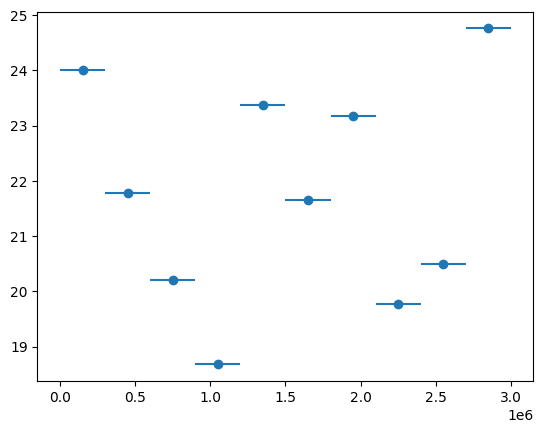

In [15]:
Nbins=10
bins=np.linspace(0,3e6,Nbins+1,endpoint=True)
nom_hist=rejection_hist(ys,preds,pts,bins,wp50)

fig, ax = plt.subplots()
ax.errorbar((bins[1:]+bins[:-1])/2, nom_hist, xerr=(bins[1:]-bins[:-1])/2,fmt='o')
fig.savefig(f"rejection_pt.pdf")

In [16]:
if not(os.path.isfile("ttbar_herwig_000.h5")):
    if sys.platform=="darwin": #MAC OSX
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/ttbar_herwig_000.h5.gz --output ttbar_herwig_000.h5.gz
    elif sys.platform == "linux" or sys.platform == "linux2":
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/ttbar_herwig_000.h5.gz 
    !gunzip -f ttbar_herwig_000.h5.gz

In [17]:
altsig_data=ATLASH5HighLevelDataset("ttbar_herwig_000.h5",return_pt=True)
altsig_dataloader = DataLoader(altsig_data, batch_size=2**8, shuffle=True)

altsig_preds_raw,altsig_ys,altsig_weights,altsig_pts=load_score(altsig_dataloader)
altsig_preds=np.log(altsig_preds_raw[:,0])/np.log(altsig_preds_raw[:,1])

In [31]:
bkg_indices=np.argwhere(ys==0)
altsig_fpr, altsig_tpr, altsig_thresholds = metrics.roc_curve(np.concatenate([altsig_ys,ys[bkg_indices].flatten()]), np.concatenate([altsig_preds,preds[bkg_indices].flatten()]), sample_weight=np.concatenate([altsig_weights,weights[bkg_indices].flatten()]))
altsig_wp50=alt_thresholds[np.argmax(altsig_tpr>0.5)]
print(alt_wp50)

1.6697688094521483


In [39]:
if not(os.path.isfile("angular_000.h5")):
    if sys.platform=="darwin": #MAC OSX
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/angular_000.h5.gz --output angular_000.h5.gz
    elif sys.platform == "linux" or sys.platform == "linux2":
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/angular_000.h5.gz
    !gunzip -f angular_000.h5.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.0M    0 80.0M    0     0  25.9M      0 --:--:--  0:00:03 --:--:-- 25.9M


In [40]:
altbkg_data=ATLASH5HighLevelDataset("angular_000.h5",return_pt=True)
altbkg_dataloader = DataLoader(altbkg_data, batch_size=2**8, shuffle=True)

altbkg_preds_raw,altbkg_ys,altbkg_weights,altbkg_pts=load_score(altbkg_dataloader)
altbkg_preds=np.log(altbkg_preds_raw[:,0])/np.log(altbkg_preds_raw[:,1])

In [42]:
altsig_hist=rejection_hist(ys,preds,pts,bins,alt_wp50)
altbkg_hist=rejection_hist(altbkg_ys,altbkg_preds,altbkg_pts,bins,wp50)

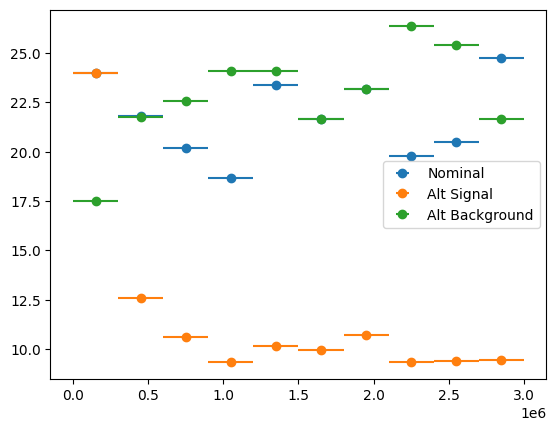

In [44]:
fig, ax = plt.subplots()
ax.errorbar((bins[1:]+bins[:-1])/2, nom_hist, xerr=(bins[1:]-bins[:-1])/2,fmt='o',label="Nominal")
ax.errorbar((bins[1:]+bins[:-1])/2, altsig_hist, xerr=(bins[1:]-bins[:-1])/2,fmt='o',label="Alt Signal")
ax.errorbar((bins[1:]+bins[:-1])/2, altbkg_hist, xerr=(bins[1:]-bins[:-1])/2,fmt='o',label="Alt Background")
plt.legend()
fig.savefig(f"rejection_comparison_pt.pdf")